## Solar

Project Solar is an attempt to equire information about envrionment sourounding a living space, analize it, and build predictions. Some of the questions the project will attempt to ask are:

> What would be optimal level of artificial light in a living space (as a counteract to its natural deficit).

> How much sound (music) would be appropriate to project to a living space. 

#### Data aquisition and uniqness

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
import datastore as ds
from helpers import reversedEnumerate, fib, get_sequence
con = ds.connect()

In [4]:
df = pd.read_sql('SELECT * FROM sensing', con=con)

In [5]:
print(df['motion'].count(), '- number of samples')
df.drop_duplicates(subset='time', keep="last", inplace=True)
print(df['motion'].count(), '- number of unique samples')

745663 - number of samples
734674 - number of unique samples


Remove rows with light or sound unregistered

In [6]:
df = df[(df[['light','sound']] != 0).all(axis=1)]
print(df['motion'].count(), '- number of samples with light and sound')

734645 - number of samples with light and sound


In [7]:
df[['light','sound']].describe()

,light,sound
count,734645.000000,734645.000000
mean,512.450570,1414.729240
std,559.634126,250.993877
min,-0.180000,342.430000
25%,2.800000,1267.260000
50%,261.910000,1540.580000
75%,971.910000,1548.370000
max,2047.000000,2047.000000


In [8]:
df.head()

,id,light,sound,motion,location,sun,time
0,1,1.93,1061.12,0,purple,night,2018-05-01 01:09:58.296
1,2,1070.88,985.75,0,green,night,2018-05-01 01:09:58.631
2,3,1.93,1059.01,0,orange,night,2018-05-01 01:10:00.118
3,4,409.09,1059.51,0,blue,night,2018-05-01 01:10:00.817
4,5,313.70,1060.39,0,black,night,2018-05-01 01:10:03.734


Indexes 

In [9]:
df['timestamp']=pd.to_datetime(df['time'].apply(lambda x: x[:-7]))
df.set_index(['id', 'timestamp'], inplace=True)

#### Review & improve light & sound distribution

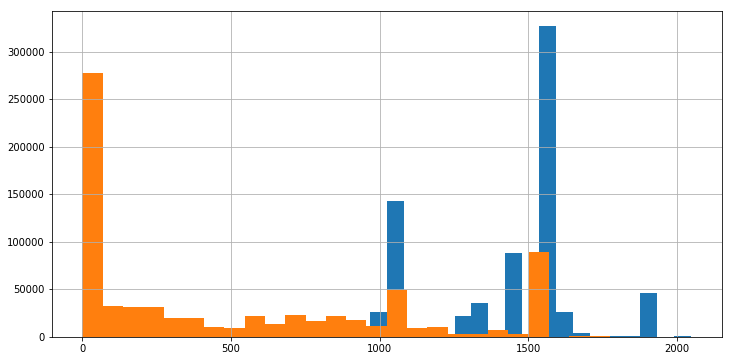

In [10]:
import numpy as np
df['sound'].hist(bins=30, figsize = (12,6))
df['light'].hist(bins=30, figsize = (12,6))

In [11]:
df['sound_log'] = np.abs(np.log(df['sound']))
df['light_log'] = np.abs(np.log(df['light']))

/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [12]:
df['sound_log'] = df['sound_log'].apply(lambda x: 0 if np.isinf(x) else x)
df['light_log'] = df['light_log'].apply(lambda x: 0 if np.isinf(x) else x)

In [13]:
df = df[(df[['light_log','sound_log']] != 0).all(axis=1)]
print(df['motion'].count(), '- number of samples with light and sound')

734645 - number of samples with light and sound


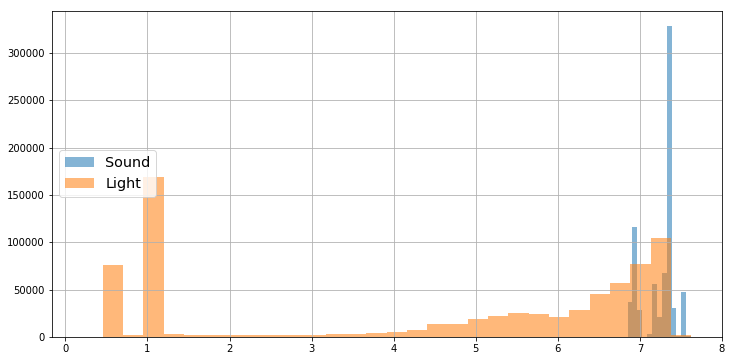

In [14]:
fig, ax = plt.subplots(figsize=(18, 10))
df['sound_log'].hist(bins=30, figsize = (12,6), label='Sound', alpha=.55)
df['light_log'].hist(bins=30, figsize = (12,6), label='Light', alpha=.55)
ax.legend(loc=6, fontsize='x-large')

#### Scaling 

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 734645 entries, (1, 2018-05-01 01:09:00) to (745663, 2018-05-29 22:43:00)
Data columns (total 8 columns):
light        734645 non-null float64
sound        734645 non-null float64
motion       734645 non-null int64
location     734645 non-null object
sun          734645 non-null object
time         734645 non-null object
sound_log    734645 non-null float64
light_log    734644 non-null float64
dtypes: float64(4), int64(1), object(3)
memory usage: 56.4+ MB


In [16]:
df = df[np.isfinite(df['light_log'])]
df = df[np.isfinite(df['sound_log'])]
print(df['motion'].count(), '- finite sampels: ', np.all(np.isfinite(df[['light_log', 'sound_log']])))

734644 - finite sampels:  True


In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
mm = MinMaxScaler()
ss = StandardScaler()

df['sound_log_mms'] = mm.fit_transform(df['sound_log'].values.reshape(-1,1))
df['light_log_mms'] = mm.fit_transform(df['light_log'].values.reshape(-1,1))

df['sound_log_sss'] = ss.fit_transform(df['sound_log'].values.reshape(-1,1))
df['light_log_sss'] = ss.fit_transform(df['light_log'].values.reshape(-1,1))

#### Focusing on last 2 weeks

In [18]:
from datetime import datetime, timedelta
N = 14
n_days_ago = datetime.now() - timedelta(days=N)
last_ndays_of_data = df.loc[df.index.get_level_values('timestamp').day > n_days_ago.day]

In [19]:
print('Number of samples: ', len(last_ndays_of_data))

Number of samples:  270373


#### Visualization

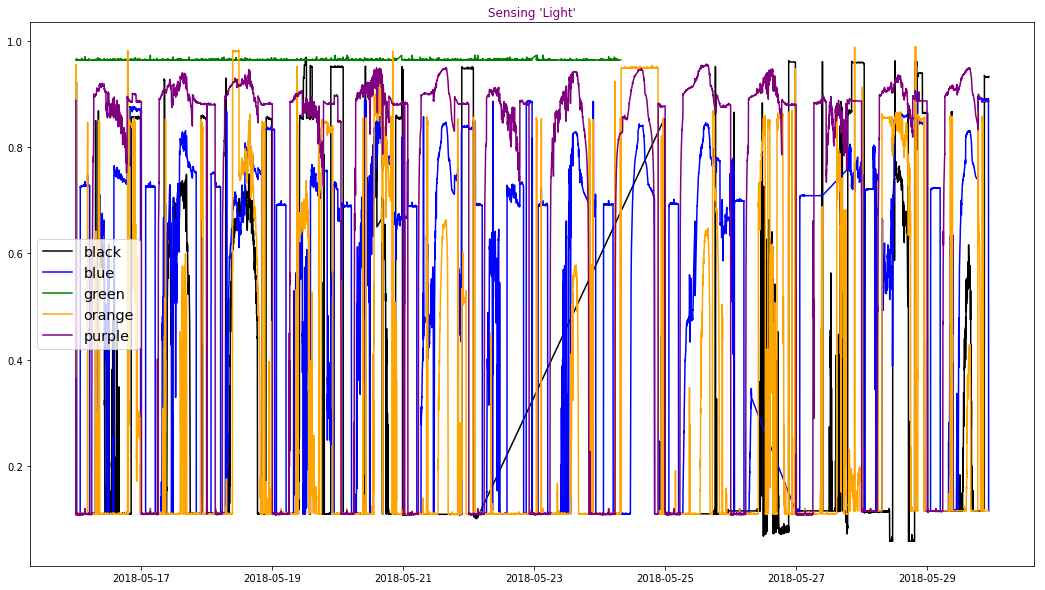

In [20]:
def draw_sensing(data, title = ''):
    fig, ax = plt.subplots(figsize=(18, 10))
    for location in data.index.get_level_values(0).unique():
        ax.set_title('Sensing {!r}'.format(title), color=location)
        ax.plot(data.loc[location], label=location, color=location)
    ax.legend(loc=6, fontsize='x-large')

draw_sensing(last_ndays_of_data[['light_log_mms', 'location']].groupby(['location', 'timestamp']).agg({'light_log_mms':'mean'}), 'Light')

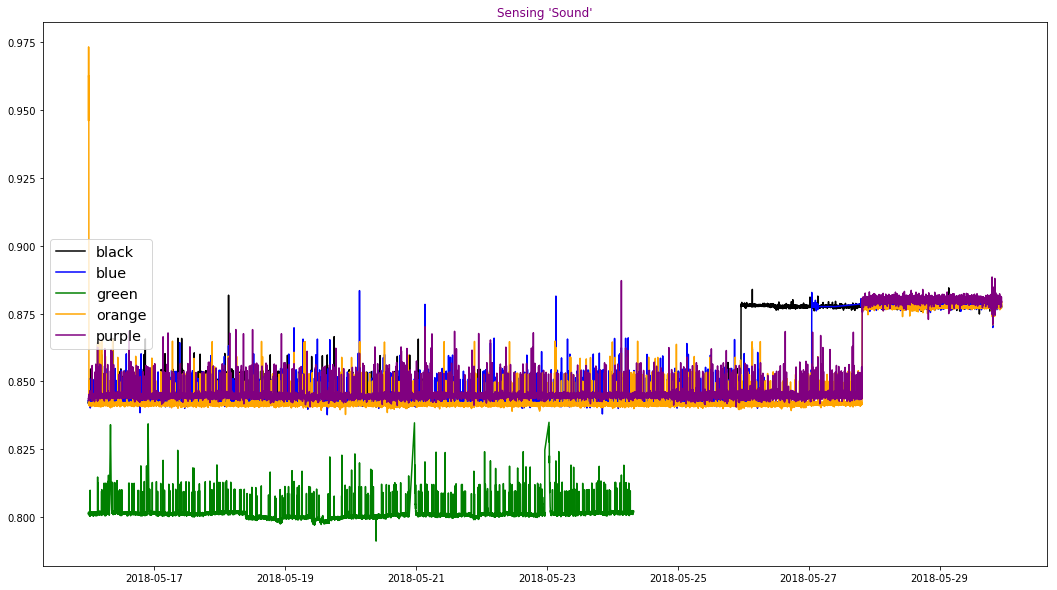

In [21]:
draw_sensing(last_ndays_of_data[['sound_log_mms', 'location']].groupby(['location', 'timestamp']).agg({'sound_log_mms':'mean'}), 'Sound')

#### Motion heatmap

In [22]:
last_ndays_of_data = last_ndays_of_data.dropna()

In [23]:
location = pd.get_dummies(last_ndays_of_data[['location']], prefix='location')

In [24]:
last_ndays_of_data = pd.concat([last_ndays_of_data, location], axis=1, join='outer')

In [25]:
last_ndays_of_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 270373 entries, (475265, 2018-05-16 00:00:00) to (745663, 2018-05-29 22:43:00)
Data columns (total 17 columns):
light              270373 non-null float64
sound              270373 non-null float64
motion             270373 non-null int64
location           270373 non-null object
sun                270373 non-null object
time               270373 non-null object
sound_log          270373 non-null float64
light_log          270373 non-null float64
sound_log_mms      270373 non-null float64
light_log_mms      270373 non-null float64
sound_log_sss      270373 non-null float64
light_log_sss      270373 non-null float64
location_black     270373 non-null uint8
location_blue      270373 non-null uint8
location_green     270373 non-null uint8
location_orange    270373 non-null uint8
location_purple    270373 non-null uint8
dtypes: float64(8), int64(1), object(3), uint8(5)
memory usage: 34.0+ MB


In [26]:
motion_df = last_ndays_of_data.groupby([
    last_ndays_of_data.index.get_level_values('timestamp').hour,
    'location_black', 
    'location_blue', 
    'location_green', 
    'location_orange', 
    'location_purple']).agg({'motion':'sum'})

Text(0.5,365.509,'Time')

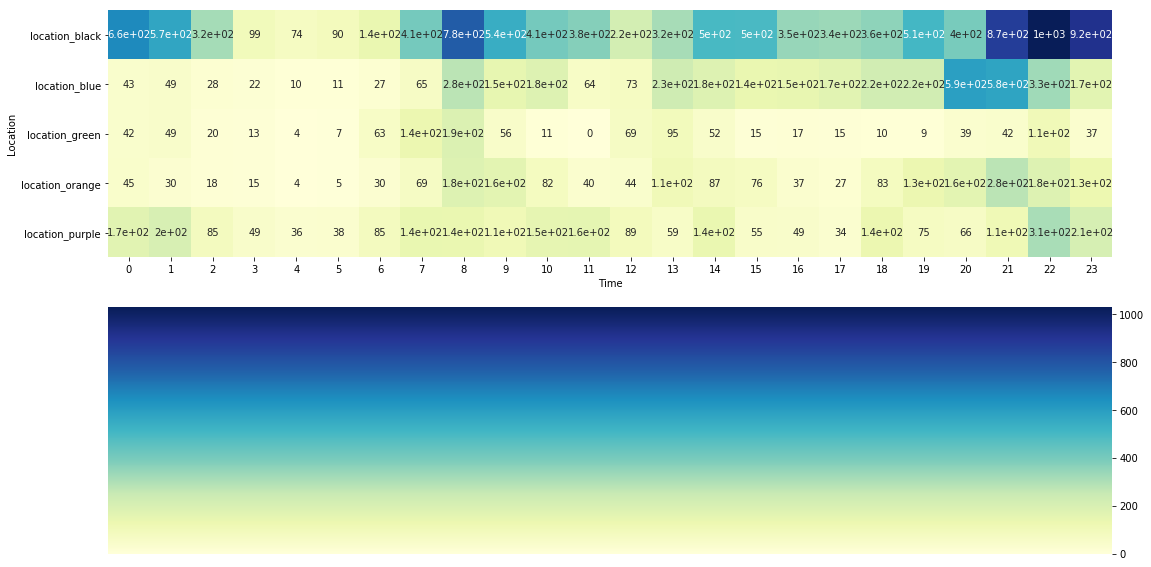

In [27]:
import re
f, (ax, cbar_ax) = plt.subplots(2, figsize=(18, 10))
xtick = motion_df.index.get_level_values('timestamp').unique()
ytick = list(map(lambda x: re.sub(r'location__', '', x), motion_df.index.names[1:]))
ytick
sns.heatmap(motion_df.unstack(level=[0]), yticklabels=ytick, xticklabels=xtick, ax=ax, cbar_ax=cbar_ax, annot=True, cmap="YlGnBu")
ax.set_ylabel('Location')
ax.set_xlabel('Time')

#### Add features

In [28]:
last_ndays_of_data['sun'].value_counts()

morning      73957
afternoon    72232
night        60338
evening      35425
noon         16508
sunrise       6143
sunset        5770
Name: sun, dtype: int64

In [29]:
last_ndays_of_data['sun_cat'] = pd.Categorical(last_ndays_of_data['sun'])

In [30]:
last_ndays_of_data['sun_cat'] = last_ndays_of_data['sun_cat'].cat.codes

In [31]:
last_ndays_of_data['sun_cat'].value_counts()

2    73957
0    72232
3    60338
1    35425
4    16508
5     6143
6     5770
Name: sun_cat, dtype: int64

Day of the week

In [32]:
day_of_week = pd.DataFrame(last_ndays_of_data.index.get_level_values('timestamp').dayofweek, index=last_ndays_of_data.index)
day_of_week.rename(columns=lambda x: 'dot_week', inplace=True)
last_ndays_of_data = pd.concat([last_ndays_of_data, day_of_week], axis=1, join='outer')

In [33]:
last_ndays_of_data['dot_week'].value_counts()

2    45366
4    42535
3    42301
5    42223
6    40468
0    29362
1    28118
Name: dot_week, dtype: int64

Light levels

In [47]:
last_ndays_of_data['light_level'] = 0
NUMBER_OF_BUCKETS = 5
SEQUENCE=[3,7,13,21,35]

def gradual_buckets(data, top_bucket):
    sequence = SEQUENCE
    beginning = data.iloc[0:1].index.get_level_values('timestamp')
    ending = data.tail(1).index.get_level_values('timestamp')
    buckets = data
    for idx, gradual in reversedEnumerate(list(reversed(sequence)), 1):
        delta_beginning = (beginning + pd.to_timedelta(gradual, unit="m"))
        time_range = pd.date_range(beginning.values[0], delta_beginning.values[0], freq='T')
        walk_up = data.loc[data.index.get_level_values('timestamp').isin(time_range)]
        walk_up_selection = data.index.get_level_values('id').isin(walk_up.index.get_level_values('id'))
        buckets.loc[walk_up_selection, 'light_level'] = idx
        print('Gradual rise: {} {}, {} {}'.format(idx, gradual, len(walk_up), len(walk_up_selection)))
    
    for idx, gradual in reversedEnumerate(list(reversed(sequence)), 1):
        dalta_ending = (ending - pd.to_timedelta(gradual, unit="m"))
        time_range = pd.date_range(dalta_ending.values[0], ending.values[0], freq='T')
        walk_down = data[data.index.get_level_values('timestamp').isin(time_range)]
        walk_down_selection = data.index.get_level_values('id').isin(walk_down.index.get_level_values('id'))
        buckets.loc[walk_down_selection, 'light_level'] = idx
        print('Gradual fall: {} {}, {} {}'.format(idx, gradual, len(walk_down), len(walk_down_selection)))
     
    return buckets

def time_between(data, start, end, top_bucket):
    indexer = data.index.get_level_values('timestamp').indexer_between_time(start, end, include_start=True, include_end=True)
    time_between = data.iloc[indexer]
    time_between['light_level'] = NUMBER_OF_BUCKETS
    print('time between', len(time_between))
    return gradual_buckets(time_between, top_bucket)

def set_workday_buckets(data):
    print('Work day', len(data))
    buckets = [
        time_between(data, '06:45', '09:10', NUMBER_OF_BUCKETS),
        time_between(data, '17:20', '23:10', NUMBER_OF_BUCKETS)
    ]
    return buckets
    
def set_weekend_buckets(data):
    print('Weekend ', len(data))
    buckets = [
        time_between(data, '08:12', '10:20', NUMBER_OF_BUCKETS),
        time_between(data, '17:20', '00:18', NUMBER_OF_BUCKETS)
    ]
    return buckets 

def update_main_data_set(data, buckets):
    for bucket in buckets:
        data.loc[(bucket.index.get_level_values('id').values), 'light_level'] = bucket['light_level']

for idx, day_of_sensing in enumerate(last_ndays_of_data.index.get_level_values('timestamp').day.unique()):
    day_data = last_ndays_of_data.loc[last_ndays_of_data.index.get_level_values('timestamp').day == day_of_sensing]
    if (len(day_data[(day_data['dot_week'] > 5)])):
        buckets = set_weekend_buckets(day_data)
        update_main_data_set(last_ndays_of_data, buckets)
    else:
        buckets = set_workday_buckets(day_data)
        update_main_data_set(last_ndays_of_data, buckets)

Work day 25250
time between 2489
Gradual rise: 5 35, 635 2489
Gradual rise: 4 21, 387 2489


/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Gradual rise: 3 13, 246 2489
Gradual rise: 2 7, 140 2489
Gradual rise: 1 3, 70 2489
Gradual fall: 5 35, 635 2489
Gradual fall: 4 21, 388 2489
Gradual fall: 3 13, 248 2489
Gradual fall: 2 7, 142 2489
Gradual fall: 1 3, 71 2489
time between 6154
Gradual rise: 5 35, 635 6154
Gradual rise: 4 21, 388 6154
Gradual rise: 3 13, 248 6154
Gradual rise: 2 7, 141 6154
Gradual rise: 1 3, 71 6154
Gradual fall: 5 35, 634 6154
Gradual fall: 4 21, 388 6154
Gradual fall: 3 13, 246 6154
Gradual fall: 2 7, 141 6154
Gradual fall: 1 3, 71 6154
Work day 25351
time between 2572
Gradual rise: 5 35, 634 2572
Gradual rise: 4 21, 387 2572
Gradual rise: 3 13, 245 2572
Gradual rise: 2 7, 140 2572
Gradual rise: 1 3, 70 2572
Gradual fall: 5 35, 634 2572
Gradual fall: 4 21, 387 2572
Gradual fall: 3 13, 247 2572
Gradual fall: 2 7, 141 2572
Gradual fall: 1 3, 70 2572
time between 6172
Gradual rise: 5 35, 635 6172
Gradual rise: 4 21, 388 6172
Gradual rise: 3 13, 247 6172
Gradual rise: 2 7, 140 6172
Gradual rise: 1 3, 70 

Gradual fall: 1 3, 21 778
time between 1724
Gradual rise: 5 35, 192 1724
Gradual rise: 4 21, 119 1724
Gradual rise: 3 13, 76 1724
Gradual rise: 2 7, 44 1724
Gradual rise: 1 3, 23 1724
Gradual fall: 5 35, 188 1724
Gradual fall: 4 21, 113 1724
Gradual fall: 3 13, 72 1724
Gradual fall: 2 7, 40 1724
Gradual fall: 1 3, 18 1724


In [117]:
last_ndays_of_data['light_level'].value_counts()

0    189040
5     81736
4      6284
3      4759
1      3172
2      3168
Name: light_level, dtype: int64

#### Presence

In [44]:
import datetime
import time
QUARTERS = [0, 15, 30, 45, 60]

def update_main_data_set(data, bucket):
    data.loc[(bucket.index.get_level_values('id').values), 'present'] = bucket['present']

def set_presence(data):
    data['present'] = False
    for day_of_sensing in last_ndays_of_data.index.get_level_values('timestamp').day.unique():
        day_data = data.loc[data.index.get_level_values('timestamp').day == day_of_sensing]
        beginning = day_data.iloc[0:1].index.get_level_values('timestamp')
        ending = day_data.tail(1).index.get_level_values('timestamp')
        #for hour_of_sensing in day_data.index.get_level_values('timestamp').hour.unique():
        #    hour_data = day_data.loc[day_data.index.get_level_values('timestamp').hour == hour_of_sensing]
        #    for idx, quarter in enumerate(QUARTERS):
        #        if ((len(QUARTERS) - idx) >= 2):
        #            bottom = QUARTERS[idx:idx+2][0]
        #            top = QUARTERS[idx:idx+2][1]
        #            quarter_data = hour_data.loc[(hour_data.index.get_level_values('timestamp').minute > bottom) &
        #                (hour_data.index.get_level_values('timestamp').minute < top)]
        #            present_not_at_night = quarter_data['motion'][quarter_data['sun_cat'] != 3].apply(lambda x: x > 0).groupby(['timestamp']).agg({'motion': 'sum'}) > 2
        #            present_at_night = quarter_data['motion'][quarter_data['sun_cat'] == 3].apply(lambda x: x > 0).groupby(['timestamp']).agg({'motion': 'sum'}) > 0
        #            entire_quarter = pd.concat([present_not_at_night, present_at_night])
        #            if(len(quarter_data) > 0):
        #                quarter_data.loc[quarter_data.index.get_level_values('timestamp').isin(entire_quarter.index.get_level_values('timestamp')), 'present'] = entire_quarter['motion'].values[0]
        #                day_data.loc[(quarter_data.index.get_level_values('id').values), 'present'] = quarter_data['present']
                    
        time_range = pd.date_range(beginning.values[0], ending.values[0], freq='15min')
        motion_in_quarter = day_data.loc[day_data.index.get_level_values('timestamp').isin(time_range)]
        for quarter in motion_in_quarter.index.get_level_values('timestamp').unique():
            quarter_by_day = day_data.loc[(day_data.index.get_level_values('timestamp') >= quarter) &
                                        (day_data.index.get_level_values('timestamp') < quarter + datetime.timedelta(minutes = 15))]
            present_not_at_night = quarter_by_day['motion'][quarter_by_day['sun_cat'] != 3].apply(lambda x: x > 0).groupby(['timestamp']).agg({'motion': 'sum'}) > 2
            present_at_night = quarter_by_day['motion'][quarter_by_day['sun_cat'] == 3].apply(lambda x: x > 0).groupby(['timestamp']).agg({'motion': 'sum'}) > 0
            entire_day = pd.concat([present_not_at_night, present_at_night])
            quarter_by_day.loc[quarter_by_day.index.get_level_values('timestamp').isin(entire_day.index.get_level_values('timestamp')), 'present'] = entire_day['motion'].values[0]
            day_data.loc[(quarter_by_day.index.get_level_values('id').values), 'present'] = quarter_by_day['present']
        
        update_main_data_set(data, day_data)

start = time.time()
set_presence(last_ndays_of_data)
end = time.time()
print(end - start)

/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/radek.czarnecki/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


KeyboardInterrupt: 

In [38]:
last_ndays_of_data['present'].value_counts()

False    214155
True      56218
Name: present, dtype: int64

In [39]:
last_ndays_of_data['present'] = last_ndays_of_data['present'].astype(int)

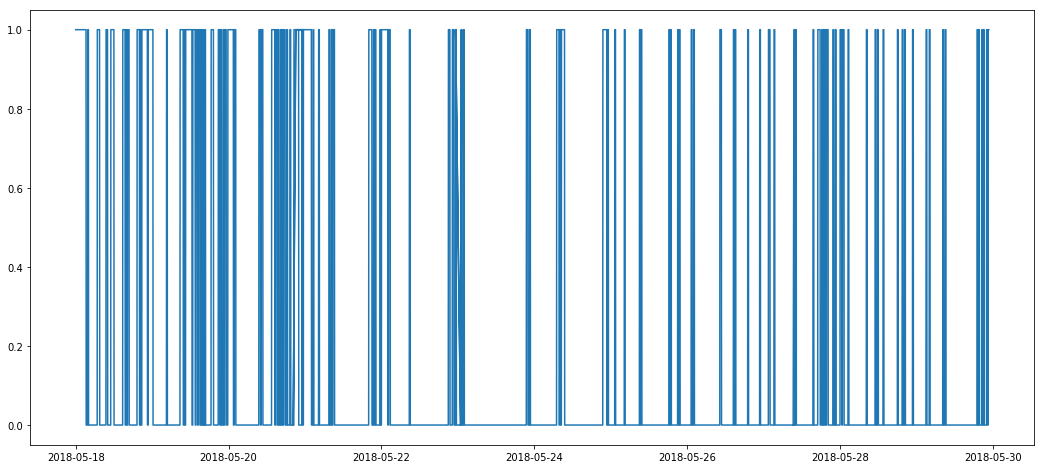

In [40]:
plt.figure(figsize = (18, 8))
one_day_data = last_ndays_of_data.loc[last_ndays_of_data.index.get_level_values('timestamp').day > 17]
plt.plot(one_day_data.index.get_level_values('timestamp'), one_day_data['present'])

#### Export data for further research

In [48]:
last_ndays_of_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 270373 entries, (475265, 2018-05-16 00:00:00) to (745663, 2018-05-29 22:43:00)
Data columns (total 21 columns):
light              270373 non-null float64
sound              270373 non-null float64
motion             270373 non-null int64
location           270373 non-null object
sun                270373 non-null object
time               270373 non-null object
sound_log          270373 non-null float64
light_log          270373 non-null float64
sound_log_mms      270373 non-null float64
light_log_mms      270373 non-null float64
sound_log_sss      270373 non-null float64
light_log_sss      270373 non-null float64
location_black     270373 non-null uint8
location_blue      270373 non-null uint8
location_green     270373 non-null uint8
location_orange    270373 non-null uint8
location_purple    270373 non-null uint8
sun_cat            270373 non-null int8
dot_week           270373 non-null int64
present            270373 non-null bool
l

In [43]:

one_day_data = last_ndays_of_data.loc[last_ndays_of_data.index.get_level_values('timestamp').day == 15]
grouped = one_day_data[['light_log_mms', 'location']].groupby(['location', 'timestamp']).agg({'light_log_mms':'mean'})

one_day_data['light_level'] = mm.fit_transform(one_day_data['light_level'].values.reshape(-1,1))


fig, ax = plt.subplots(figsize=(18, 10))
ax.set_title('Light level buckets')
ax.plot(one_day_data.index.get_level_values('timestamp'), one_day_data['light_level'], label='Light level', lw=5)
#ax.plot(data.loc[location], label=location, color=location)
ax.plot(grouped.loc['purple'], label='purple')
ax.plot(grouped.loc['blue'], label='blue')
ax.plot(grouped.loc['black'], label='black')
ax.legend(loc=6, fontsize='x-large')

KeyError: 'light_level'

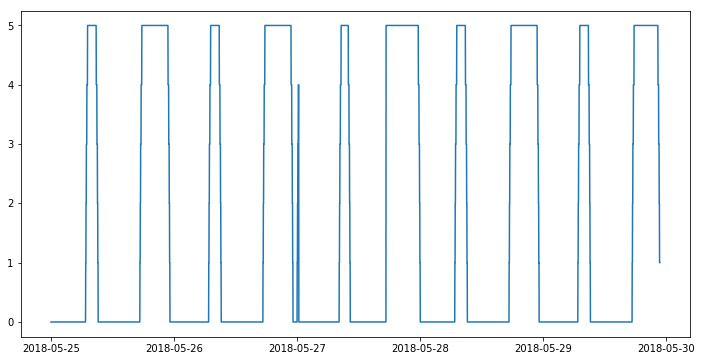

In [51]:
plt.figure(figsize = (12, 6))
plt.plot(saturday_data.index.get_level_values('timestamp'), saturday_data['light_level'])

In [52]:
from sklearn.externals import joblib
filename = 'data/sensing_numeric.sav'
export = last_ndays_of_data[last_ndays_of_data.columns.difference(['light','sound','location','time','sun','sound_log','light_log'])]
joblib.dump(export, filename)

['data/sensing_numeric.sav']